In [1]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import numpy as np
import time
from rich.progress import track
from rich.progress import Progress
import scipy.special as sciSpec

import Backend.InteractionPoint as inp
import Backend.Detuning as dtune
import Backend.Footprint as fp
import Backend.BeamPhysics as BP
import Backend.Constants as cst

# Importing twiss and survey
twiss_b1  = pd.read_pickle('LHC_sequence/lhcb1_opticsfile30_twiss.pkl')
survey_b1 = pd.read_pickle('LHC_sequence/lhcb1_opticsfile30_survey.pkl')

twiss_b2  = pd.read_pickle('LHC_sequence/lhcb2_opticsfile30_twiss.pkl')
survey_b2 = pd.read_pickle('LHC_sequence/lhcb2_opticsfile30_survey.pkl')


B1 = inp.Beam('b1',twiss_b1,survey_b1,
              Nb       = 1.15e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)
    
B2 = inp.Beam('b2',twiss_b2,survey_b2,
              Nb       = 1.15e11,
              E        = 6.8e12,
              emittx_n = 2.5e-6,
              emitty_n = 2.5e-6,
              dp_p0    = 0)

IP1 = inp.InteractionPoint('ip1',B1,B2)
IP5 = inp.InteractionPoint('ip5',B1,B2)

# Test equations... on axis

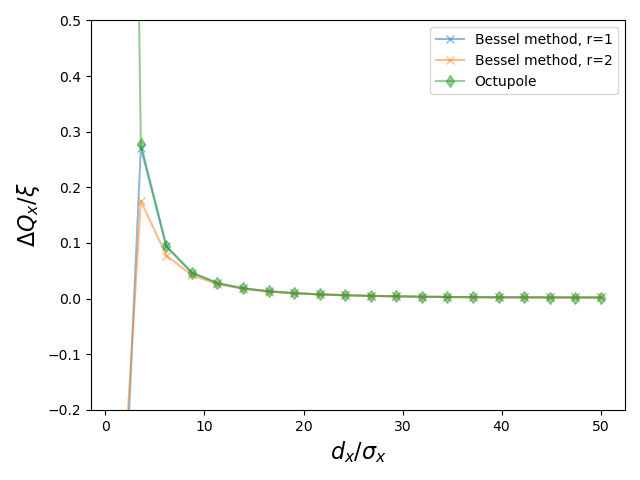

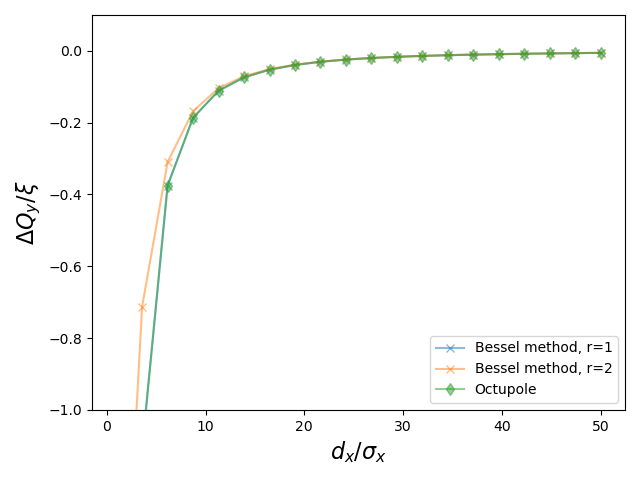

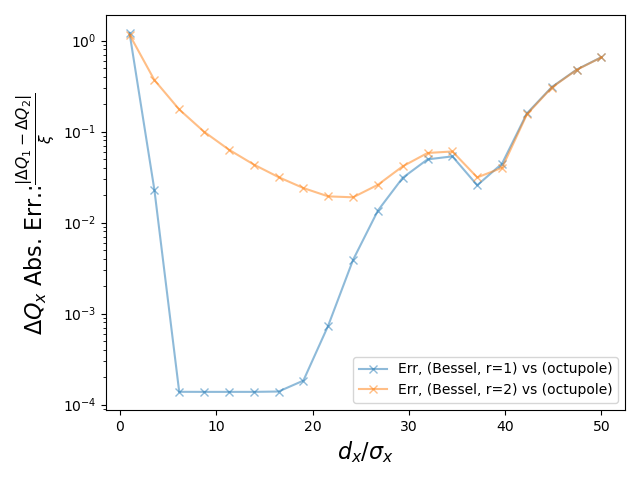

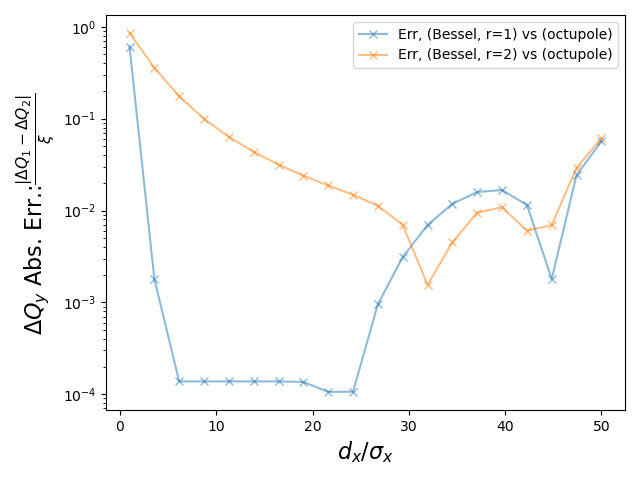

In [16]:

_IP = IP5

dx_n_vec = np.linspace(1,50,20)

sigx_s = 150e-6
sigx_w = 200e-6
sigy_w = 400e-6


AX = 1e-6
AY = 1e-6

Bess1_DQx,Bess1_DQy = [],[]

for _dx_n in dx_n_vec:
    
    r = 1
    A_w_s = sigx_w/(r*sigx_s)
    B_w_s = sigy_w/sigx_s
    
    _DQx,_DQy = dtune.DQx_DQy( ax   = [A_w_s*AX],
                               ay   = [B_w_s*AY],
                               r    = r,
                               dx_n = _dx_n,
                               dy_n = 0,
                               xi   = _IP.b2.xi)

    Bess1_DQx += list(A_w_s**2*_DQx)
    Bess1_DQy += list(B_w_s**2*_DQy)
    

Bess2_DQx,Bess2_DQy = [],[]

for _dx_n in dx_n_vec:
    r = 2
    A_w_s = sigx_w/(r*sigx_s)
    B_w_s = sigy_w/sigx_s
    
    _DQx,_DQy = dtune.DQx_DQy( ax   = [A_w_s*AX],
                               ay   = [B_w_s*AY],
                               r    = r,
                               dx_n = _dx_n,
                               dy_n = 0,
                               xi   = _IP.b2.xi)

    Bess2_DQx += list(A_w_s**2*_DQx)
    Bess2_DQy += list(B_w_s**2*_DQy)
    
    

oct_DQx,oct_DQy = [],[]
for _dx_n in dx_n_vec:
    
  
    k1 = _IP.b2.strong_knl(_dx_n*sigx_s,0)[0][1]
    k3 = _IP.b2.strong_knl(_dx_n*sigx_s,0)[0][3]
    
    betx  = sigx_w**2/_IP.b1.emittx
    bety  = sigy_w**2/_IP.b1.emitty
    
    
    _DQx,_DQy = dtune.BBLR_octupole(  Jx   = (AX)**2*_IP.b1.emittx/2,
                                      Jy   = (AY)**2*_IP.b1.emittx/2,
                                      betx = betx,
                                      bety = bety,
                                      k1   = k1,
                                      k3   = k3)
    
    oct_DQx.append(_DQx)
    oct_DQy.append(_DQy)

    
    

plt.figure()
plt.plot(dx_n_vec ,np.array(Bess1_DQx)/_IP.b2.xi,'-x',alpha=0.5,label='Bessel method, r=1')
plt.plot(dx_n_vec ,np.array(Bess2_DQx)/_IP.b2.xi,'-x',alpha=0.5,label='Bessel method, r=2')
plt.plot(dx_n_vec ,np.array(oct_DQx)/_IP.b2.xi,'-d',alpha=0.5,label='Octupole')

plt.ylabel(r'$\Delta Q_x/\xi$',fontsize=16)
plt.xlabel(r'$d_x/\sigma_x$',fontsize=16)
plt.ylim([-0.2,0.5])
plt.legend()

plt.tight_layout()

plt.figure()
plt.plot(dx_n_vec ,np.array(Bess1_DQy)/_IP.b2.xi,'-x',alpha=0.5,label='Bessel method, r=1')
plt.plot(dx_n_vec ,np.array(Bess2_DQy)/_IP.b2.xi,'-x',alpha=0.5,label='Bessel method, r=2')
plt.plot(dx_n_vec ,np.array(oct_DQy)/_IP.b2.xi,'-d',alpha=0.5,label='Octupole')

plt.ylabel(r'$\Delta Q_y/\xi$',fontsize=16)
plt.xlabel(r'$d_x/\sigma_x$',fontsize=16)
plt.ylim([-1,0.1])
plt.legend()

plt.tight_layout()

plt.figure()
#Err1 = np.abs((np.array(Bess1_DQx)- np.array(oct_DQx)))/_IP.b2.xi#/(np.array(oct_DQx)))
#Err2 = np.abs((np.array(Bess2_DQx)- np.array(oct_DQx)))/_IP.b2.xi#/(np.array(oct_DQx)))

Err1 = np.abs(((np.array(Bess1_DQx)- np.array(oct_DQx)))/(np.array(oct_DQx)))
Err2 = np.abs(((np.array(Bess2_DQx)- np.array(oct_DQx)))/(np.array(oct_DQx)))


plt.plot(dx_n_vec ,Err1,'-x',alpha=0.5,label='Err, (Bessel, r=1) vs (octupole)')
plt.plot(dx_n_vec ,Err2,'-x',alpha=0.5,label='Err, (Bessel, r=2) vs (octupole)')

plt.legend()
plt.xlabel(r'$d_x/\sigma_x$',fontsize=16)
plt.ylabel(r'$\Delta Q_x$ Abs. Err.:$\frac{|\Delta Q_1-\Delta Q_2|}{\xi}$ ',fontsize=16)
plt.yscale('log') 
#plt.ylim([-1,5])
plt.tight_layout()


plt.figure()
#Err1 = np.abs((np.array(Bess1_DQy)- np.array(oct_DQy)))/_IP.b2.xi#/(np.array(oct_DQx)))
#Err2 = np.abs((np.array(Bess2_DQy)- np.array(oct_DQy)))/_IP.b2.xi#/(np.array(oct_DQx)))

Err1 = np.abs(((np.array(Bess1_DQy)- np.array(oct_DQy)))/(np.array(oct_DQy)))
Err2 = np.abs(((np.array(Bess2_DQy)- np.array(oct_DQy)))/(np.array(oct_DQy)))

plt.plot(dx_n_vec ,Err1,'-x',alpha=0.5,label='Err, (Bessel, r=1) vs (octupole)')
plt.plot(dx_n_vec ,Err2,'-x',alpha=0.5,label='Err, (Bessel, r=2) vs (octupole)')

plt.legend()
plt.xlabel(r'$d_x/\sigma_x$',fontsize=16)
plt.ylabel(r'$\Delta Q_y$ Abs. Err.:$\frac{|\Delta Q_1-\Delta Q_2|}{\xi}$ ',fontsize=16)
plt.yscale('log') 
#plt.ylim([-1,5])
plt.tight_layout()


## Long range test










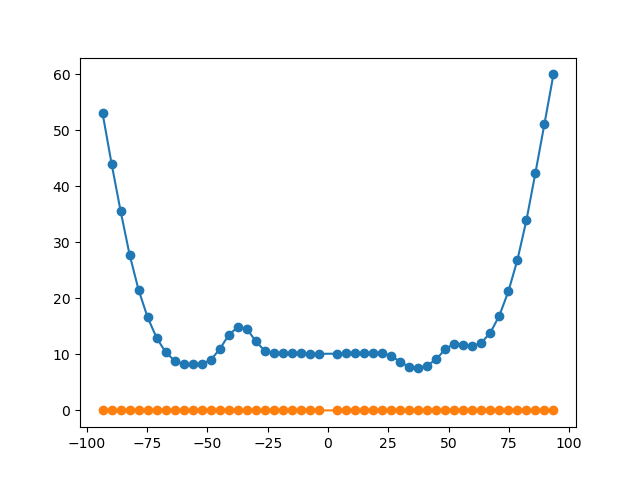

In [8]:
_IP = IP5

study = _IP.lr.copy()

plt.figure()
plt.plot(study['s'],np.abs(study['dx_n']),'-o')
plt.plot(study['s'],np.abs(study['dy_n']),'-o')

In [45]:
dtune.DQx_DQy( ax   = [_lr['A_w_s']*-AX],
                                   ay   = [_lr['B_w_s']*1e-6],
                                   r    = _lr['r'],
                                   dx_n = _lr['dx_n'],
                                   dy_n = _lr['dy_n'],
                                   xi   = _IP.b2.xi)

(array([3.94997422e-06]), array([-2.45313145e-06]))

In [14]:
_IP = IP5

study = _IP.lr.copy()

#study['dx']   *= 2
#study['dx_n'] *= 2

#study['k1'] = [_IP.b2.strong_knl(_dx,_dy)[0][1] for _dx,_dy in zip(study['dx'],study['dy'])]
#study['k3'] = [_IP.b2.strong_knl(_dx,_dy)[0][3] for _dx,_dy in zip(study['dx'],study['dy'])]




sigx_s = 150e-6
sigx_w = 200e-6
sigy_w = 400e-6

Bess_migration_X = []
Bess_migration_Y = []
oct_migration_X = []
oct_migration_Y = []
AX_vec = [1e-3,1,1.5,2,2.5]

for AX in AX_vec:

    Bess_DQx,Bess_DQy = [], []
    oct_DQx,oct_DQy   = [], []
    
    for index, _lr in study.iterrows():
        _DQx,_DQy = dtune.DQx_DQy( ax   = [_lr['A_w_s']*AX],
                                   ay   = [_lr['B_w_s']*1e-6],
                                   r    = _lr['r'],
                                   dx_n = _lr['dx_n'],
                                   dy_n = _lr['dy_n'],
                                   xi   = _IP.b2.xi)

        Bess_DQx.append(_lr['A_w_s']**2*_DQx)
        Bess_DQy.append(_lr['B_w_s']**2*_DQy)


        #============================================================
        _DQx,_DQy = dtune.BBLR_octupole(  Jx   = (AX)**2*_IP.b2.emittx/2,
                                          Jy   = (1e-6)**2*_IP.b2.emittx/2,
                                          betx = _lr['betx'],
                                          bety = _lr['bety'],
                                          k1   = _lr['k1'],
                                          k3   = _lr['k3'])

        oct_DQx.append(_DQx)
        oct_DQy.append(_DQy)

        
        
    
    Bess_migration_X.append(np.cumsum(Bess_DQx))
    Bess_migration_Y.append(np.cumsum(Bess_DQy))
    oct_migration_X.append(np.cumsum(oct_DQx))
    oct_migration_Y.append(np.cumsum(oct_DQy))
    
Qx_0,Qy_0 = 0.31,0.32





if False:
    plt.figure()
    plt.suptitle(f'Migration of Qx,Qy for on-axis particle, right of {_IP.name}')
    plt.plot(Qx_0+np.cumsum(oct_DQx),Qy_0+np.cumsum(oct_DQy),'-o',alpha=0.6,label='Octupolar term')
    plt.plot(Qx_0+np.cumsum(Bess_DQx),Qy_0+np.cumsum(Bess_DQy),'-o',alpha=0.6,label=r'Bessel, cst. $\xi$')
    #plt.plot(Qx_0+np.cumsum(Bess_s_DQx),Qy_0+np.cumsum(Bess_s_DQy),'-o',alpha=0.6,label=r'Bessel, $\xi(s)$')
    #plt.plot(Qx_0+np.cumsum(quad_DQx),Qy_0+np.cumsum(quad_DQy),'-o',alpha=0.6,label='quad term')
    plt.plot([Qx_0],[Qy_0],'P',markersize=5,alpha=0.6,color='C3',label='Unperturbed W.P.')
    plt.legend()
    plt.xlabel(r'$\Delta Q_x$')
    plt.ylabel(r'$\Delta Q_y$')
    plt.tight_layout()

    plt.figure()
    plt.suptitle(f'Error of Qx for on-axis particle, right of {_IP.name}')
    plt.plot(study['s'],np.cumsum(oct_DQx)-np.cumsum(Bess_DQx),'-o',alpha=0.6)
    #plt.plot(study['s'],np.cumsum(Bess_DQx),'-o',alpha=0.6,label=r'Bessel, cst. $\xi$')

    plt.legend()
    plt.xlabel(r'$s$')
    plt.ylabel(r'$\Delta Q_x$')
    plt.tight_layout()

    plt.figure()
    plt.suptitle(f'Ratio of DQx,DQy, right of {_IP.name}')
    plt.plot(study['s'],np.cumsum(oct_DQx)/np.cumsum(Bess_DQx),label=r'$\Delta Q_x$')
    plt.plot(study['s'],np.cumsum(oct_DQy)/np.cumsum(Bess_DQy),label=r'$\Delta Q_x$')


    plt.figure()
    plt.suptitle(f'Ratio of DQx,DQy, right of {_IP.name}')
    plt.plot(study['s'],_IP.b1.get_betx(study['s'])/_IP.b2.get_betx(study['s']),label=r'$\beta_x$')
    plt.plot(study['s'],_IP.b1.get_bety(study['s'])/_IP.b2.get_bety(study['s']),label=r'$\beta_x$')

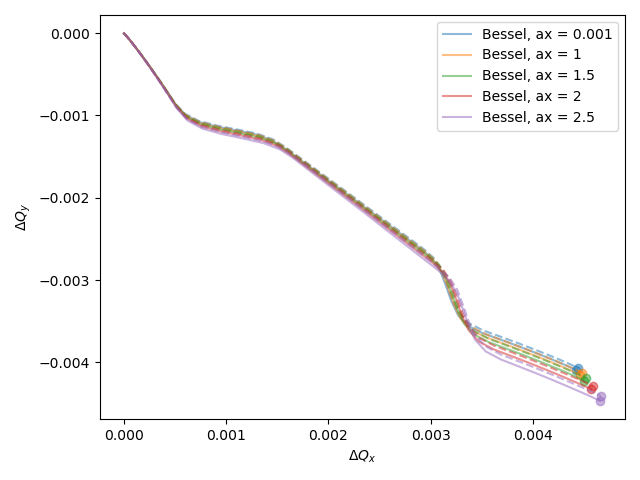

In [15]:
Qx_0,Qy_0 = 0.31,0.32

plt.close('all')
plt.figure()
color = 0
for AX,migr_Bess_X,migr_Bess_Y,migr_oct_X,migr_oct_Y in zip(AX_vec, Bess_migration_X, Bess_migration_Y,oct_migration_X, oct_migration_Y):
    
    plt.plot(migr_Bess_X,migr_Bess_Y,'-',alpha=0.5,color=f'C{color}',label=f'Bessel, ax = {AX}')
    
    plt.plot(migr_Bess_X[-1:],migr_Bess_Y[-1:],'o',alpha=0.5,color=f'C{color}')
    
    plt.plot(migr_oct_X,migr_oct_Y,'--',alpha=0.5,color=f'C{color}')
    
    plt.plot(migr_oct_X[-1:],migr_oct_Y[-1:],'o',alpha=0.5,color=f'C{color}')
    
    color += 1
    
plt.legend()
plt.xlabel(r'$\Delta Q_x$')
plt.ylabel(r'$\Delta Q_y$')
plt.tight_layout()

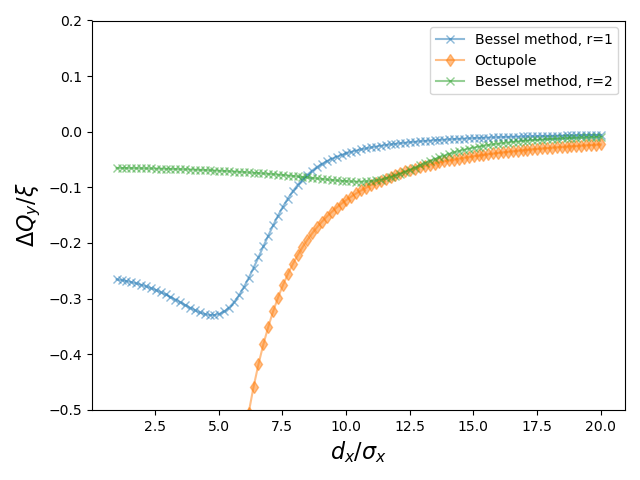

In [8]:
plt.figure()
plt.plot(dx_vec ,np.array(Bess1_DQy)/IP1.b2.xi,'-x',alpha=0.5,label='Bessel method, r=1')
plt.plot(dx_vec ,np.array(oct_DQy)/IP1.b2.xi,'-d',alpha=0.5,label='Octupole')
plt.plot(dx_vec ,np.array(Bess2_DQy)/IP1.b2.xi,'-x',alpha=0.5,label='Bessel method, r=2')
#plt.plot(dx_vec ,np.array(Bess_DQy)/IP1.b2.xi,'-x',alpha=0.5,label='Bessel method -y')
#plt.plot(dx_vec ,2/dx_vec**2,'-o',alpha=0.5,label='Quadrupolar tune shift')
#plt.plot(dx_vec ,-2/dx_vec**2,'-o',alpha=0.5,label='Quadrupolar tune shift')
#plt.plot(dx_vec,chao_DQx/IP1.b2.xi)

#plt.plot(ax_vec,_DQy/IP1.b2.xi)
plt.ylabel(r'$\Delta Q_y/\xi$',fontsize=16)
plt.xlabel(r'$d_x/\sigma_x$',fontsize=16)
plt.ylim([-0.5,0.2])
plt.legend()

plt.tight_layout()

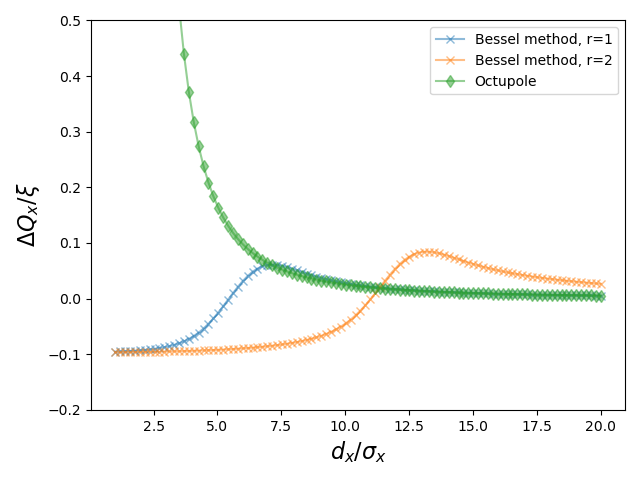

In [5]:
plt.figure()
plt.plot(dx_vec ,np.array(Bess1_DQx)/IP1.b2.xi,'-x',alpha=0.5,label='Bessel method, r=1')
plt.plot(dx_vec ,np.array(Bess2_DQx)/IP1.b2.xi,'-x',alpha=0.5,label='Bessel method, r=2')
plt.plot(dx_vec ,np.array(oct_DQx)/IP1.b2.xi,'-d',alpha=0.5,label='Octupole')

#plt.plot(dx_vec ,np.array(Bess_DQy)/IP1.b2.xi,'-x',alpha=0.5,label='Bessel method -y')
#plt.plot(dx_vec ,2/dx_vec**2,'-o',alpha=0.5,label='Quadrupolar tune shift')
#plt.plot(dx_vec ,-2/dx_vec**2,'-o',alpha=0.5,label='Quadrupolar tune shift')
#plt.plot(dx_vec,chao_DQx/IP1.b2.xi)

#plt.plot(ax_vec,_DQy/IP1.b2.xi)
plt.ylabel(r'$\Delta Q_x/\xi$',fontsize=16)
plt.xlabel(r'$d_x/\sigma_x$',fontsize=16)
plt.ylim([-0.2,0.5])
plt.legend()

plt.tight_layout()


In [61]:
import scipy.special as sciSpec

def Bess2D_SUMM(X,Y,n):
    qmax = 30
    order = np.arange(-qmax,qmax+1)
    
    q,XX = np.meshgrid(order,X)
    _,YY = np.meshgrid(order,Y)
    
    return np.exp(-X-Y)*np.sum(sciSpec.iv(n-2*q,XX)*sciSpec.iv(q,YY),axis=1)

In [68]:
%%timeit
Bess2D_SUMM(np.array([5,6,7]),np.array([5,6,7]),0)

156 µs ± 252 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [67]:
%%timeit
np.array([dtune.Bess2D(_X,_Y,0) for _X,_Y in zip(np.array([5,6,7]),np.array([5,6,7]))])

5.3 ms ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [69]:
5.3e-3/156e-6

33.97435897435898

In [43]:
X = np.linspace(2,10,20)
qmax = 30
q = np.arange(-qmax,qmax+1)

order,XX = np.meshgrid([1,2,3],X)

sciSpec.iv([0,1],X)

ValueError: operands could not be broadcast together with shapes (2,) (20,) 

In [51]:
order,XX = np.meshgrid([1,2,3],X)
test  =sciSpec.iv(order,XX)

In [60]:
np.sum(test,axis=1)

array([2.49232526e+00, 3.92669441e+00, 6.08929653e+00, 9.34967585e+00,
       1.42625756e+01, 2.16612997e+01, 3.27980360e+01, 4.95548686e+01,
       7.47611944e+01, 1.12671329e+02, 1.69683322e+02, 2.55421040e+02,
       3.84363467e+02, 5.78298475e+02, 8.70019036e+02, 1.30889212e+03,
       1.96925072e+03, 2.96304276e+03, 4.45889963e+03, 6.71088799e+03])

# On-Axis evolution

In [2]:
def DQx_DQy_s_dep(ax,ay,r,dx_n,dy_n,xi_x,xi_y):
    """
    Notes: 
    The function expects an array for ax,ay, and a single value for the other parameters
    --------
    ax,ay -> normalized amplitude, ax = x/sigma_weak
    r     -> sigma_y/sigma_x
    dx,sy -> normalized bb separation, dx_n = dx/sigma_strong
    xi    -> beam-beam parameter
    """
    DQx = np.array([2*xi_x*dtune.dC00dx(_ax,_ay,r,dx_n,dy_n)/_ax for _ax,_ay in zip(ax,ay)])
    DQy = np.array([2*xi_y*dtune.dC00dy(_ax,_ay,r,dx_n,dy_n)/_ay for _ax,_ay in zip(ax,ay)])
    return DQx,DQy

In [9]:
[_IP.b2.strong_knl(_dx,_dy)[0][3]-_IP.b1.strong_knl(_dx,_dy)[0][3] for _dx,_dy in zip(study['dx'],study['dy'])]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [6]:
[_IP.b1.strong_knl(_dx,_dy)[0][1] for _dx,_dy in zip(study['dx'],study['dy'])]

[5.977914543373721e-10,
 8.120109602525926e-10,
 1.1659822455814305e-09,
 1.7987412262283625e-09,
 2.8354785845090696e-09,
 4.475686909705921e-09,
 6.9652013910137194e-09,
 1.0237602066242737e-08,
 1.3361684712313169e-08,
 1.4566868632626071e-08,
 1.3747485028852951e-08,
 1.3053494249853069e-08,
 1.2832649392467466e-08,
 1.288105213480621e-08,
 1.31246181987035e-08,
 1.4205340291007167e-08,
 1.656695335597837e-08,
 2.1004459738357943e-08,
 2.7731543450952446e-08,
 3.7769102677159264e-08,
 5.438752348262408e-08,
 8.498054206860756e-08,
 1.5107662775761548e-07,
 3.399229008159163e-07,
 1.3596974636243013e-06,
 1.3596740224090802e-06,
 3.3991997066401373e-07,
 1.5107575956445915e-07,
 8.49801757996197e-08,
 5.438733595290231e-08,
 3.776899415301471e-08,
 2.773201754368111e-08,
 2.1006160540946995e-08,
 1.656931507721436e-08,
 1.4207497229226783e-08,
 1.3126213478664803e-08,
 1.288159636549955e-08,
 1.2832036288037652e-08,
 1.305234602173698e-08,
 1.3746300903574086e-08,
 1.456567051859569

In [10]:
_IP = IP5

study = _IP.lr.copy()#_IP.lr[_IP.lr['s']>=0].copy()

#Testing single plane
study['dy']   = 0
study['dy_n'] = 0

study['dx']   *= 5
study['dx_n'] *= 5


#study['r'] = 1

#betx  = _IP.b2.xi*4*np.pi*_IP.b2.gamma_r/_IP.b2.Nb/cst.r_p
#study['betx'] = betx
#study['bety'] = betx


study['k1'] = [_IP.b1.strong_knl(-_dx,-_dy)[0][1] for _dx,_dy in zip(study['dx'],study['dy'])]
study['k3'] = [_IP.b1.strong_knl(-_dx,-_dy)[0][3] for _dx,_dy in zip(study['dx'],study['dy'])]



xi_x_s = _IP.b2.xi*_IP.b1.get_betx(study['s'])/_IP.b2.get_betx(study['s'])#_IP.b2.Nb*cst.r_p*_IP.b1.get_betx(study['s'])/(2*np.pi*_IP.b1.gamma_r*_IP.b2.get_sigx(study['s'])**2*(1+study['r']))
xi_y_s = _IP.b2.xi*_IP.b1.get_bety(study['s'])/_IP.b2.get_bety(study['s'])#_IP.b2.Nb*cst.r_p*_IP.b1.get_bety(study['s'])/(2*np.pi*_IP.b1.gamma_r*_IP.b2.get_sigy(study['s'])**2*(1+1/study['r']))

study.insert(0,'xi_x',xi_x_s)
study.insert(1,'xi_y',xi_y_s)


#plt.figure()
#plt.plot(study['s'],xi_x_s,label=r'$\xi_x(s)$')
#plt.plot(study['s'],xi_y_s,label=r'$\xi_y(s)$')
#plt.plot([0],[_IP.b1.xi],'o',alpha=0.6,color='C3',label='@IP')
#plt.legend()


Bess_migration_X = []
Bess_migration_Y = []
oct_migration_X = []
oct_migration_Y = []
AX_vec = [2,3,4,5,6,7]
for AX in AX_vec:

    Bess_DQx,Bess_DQy = [], []
    #Bess_s_DQx,Bess_s_DQy = [], []
    oct_DQx,oct_DQy   = [], []
    #quad_DQx,quad_DQy   = [], []
    for index, _lr in study.iterrows():
        _DQx,_DQy = dtune.DQx_DQy( ax   = [AX],
                                   ay   = [1e-1],
                                   r    = _lr['r'],
                                   dx_n = _lr['dx_n'],
                                   dy_n = _lr['dy_n'],
                                   xi   = _IP.b2.xi)

        Bess_DQx.append(_DQx)
        Bess_DQy.append(_DQy)

        #_DQx,_DQy = DQx_DQy_s_dep( ax   = [AX],
        #                           ay   = [1e-1],
        #                           r    = _lr['r'],
        #                           dx_n = _lr['dx_n'],
        #                           dy_n = _lr['dy_n'],
        #                           xi_x = _lr['xi_x'],
        #                           xi_y = _lr['xi_y'])

        #Bess_s_DQx.append(_DQx)
        #Bess_s_DQy.append(_DQy)


        #k1 = IP5.b2.strong_knl(_lr['dx_n'],0)[0][1]
        #k3 = IP5.b2.strong_knl(_lr['dx_n'],0)[0][3]
        _DQx,_DQy = dtune.BBLR_octupole(  Jx   = (AX)**2*_IP.b2.emittx/2,
                                          Jy   = (1e-1)**2*_IP.b2.emittx/2,
                                          betx = _lr['betx'],
                                          bety = _lr['bety'],
                                          k1   = _lr['k1'],
                                          k3   = _lr['k3'])

        oct_DQx.append(_DQx)
        oct_DQy.append(_DQy)

      #  _DQx,_DQy = _lr['xi_x']*(1+_lr['r'])/_lr['dx_n']**2,_lr['xi_y']*(1+1/_lr['r'])/_lr['dy_n']**2
      #  
      #  quad_DQx.append(_DQx)
      #  quad_DQy.append(_DQy)
    
    Bess_migration_X.append(np.cumsum(Bess_DQx))
    Bess_migration_Y.append(np.cumsum(Bess_DQy))
    oct_migration_X.append(np.cumsum(oct_DQx))
    oct_migration_Y.append(np.cumsum(oct_DQy))
    
Qx_0,Qy_0 = 0.31,0.32





if False:
    plt.figure()
    plt.suptitle(f'Migration of Qx,Qy for on-axis particle, right of {_IP.name}')
    plt.plot(Qx_0+np.cumsum(oct_DQx),Qy_0+np.cumsum(oct_DQy),'-o',alpha=0.6,label='Octupolar term')
    plt.plot(Qx_0+np.cumsum(Bess_DQx),Qy_0+np.cumsum(Bess_DQy),'-o',alpha=0.6,label=r'Bessel, cst. $\xi$')
    #plt.plot(Qx_0+np.cumsum(Bess_s_DQx),Qy_0+np.cumsum(Bess_s_DQy),'-o',alpha=0.6,label=r'Bessel, $\xi(s)$')
    #plt.plot(Qx_0+np.cumsum(quad_DQx),Qy_0+np.cumsum(quad_DQy),'-o',alpha=0.6,label='quad term')
    plt.plot([Qx_0],[Qy_0],'P',markersize=5,alpha=0.6,color='C3',label='Unperturbed W.P.')
    plt.legend()
    plt.xlabel(r'$\Delta Q_x$')
    plt.ylabel(r'$\Delta Q_y$')
    plt.tight_layout()

    plt.figure()
    plt.suptitle(f'Error of Qx for on-axis particle, right of {_IP.name}')
    plt.plot(study['s'],np.cumsum(oct_DQx)-np.cumsum(Bess_DQx),'-o',alpha=0.6)
    #plt.plot(study['s'],np.cumsum(Bess_DQx),'-o',alpha=0.6,label=r'Bessel, cst. $\xi$')

    plt.legend()
    plt.xlabel(r'$s$')
    plt.ylabel(r'$\Delta Q_x$')
    plt.tight_layout()

    plt.figure()
    plt.suptitle(f'Ratio of DQx,DQy, right of {_IP.name}')
    plt.plot(study['s'],np.cumsum(oct_DQx)/np.cumsum(Bess_DQx),label=r'$\Delta Q_x$')
    plt.plot(study['s'],np.cumsum(oct_DQy)/np.cumsum(Bess_DQy),label=r'$\Delta Q_x$')


    plt.figure()
    plt.suptitle(f'Ratio of DQx,DQy, right of {_IP.name}')
    plt.plot(study['s'],_IP.b1.get_betx(study['s'])/_IP.b2.get_betx(study['s']),label=r'$\beta_x$')
    plt.plot(study['s'],_IP.b1.get_bety(study['s'])/_IP.b2.get_bety(study['s']),label=r'$\beta_x$')

/home/pbelange/abp/BBFootprint/Backend/Detuning.py:58: RuntimeWarning: overflow encountered in double_scalars
  return sign*np.exp(-X-2*Y)/2/np.pi * integratedFactor
/home/pbelange/abp/BBFootprint/Backend/Detuning.py:83: RuntimeWarning: invalid value encountered in double_scalars
  return np.exp(-t/2*(azbar-dzbar)**2)*Bess2D(X,Y,0)
/home/pbelange/abp/BBFootprint/Backend/Detuning.py:138: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(lambda t: dC00dy_generating(t,ax,ay,r,dx_n,dy_n,method), 0, 1)[0]
/home/pbelange/abp/BBFootprint/Backend/Detuning.py:138: Integra

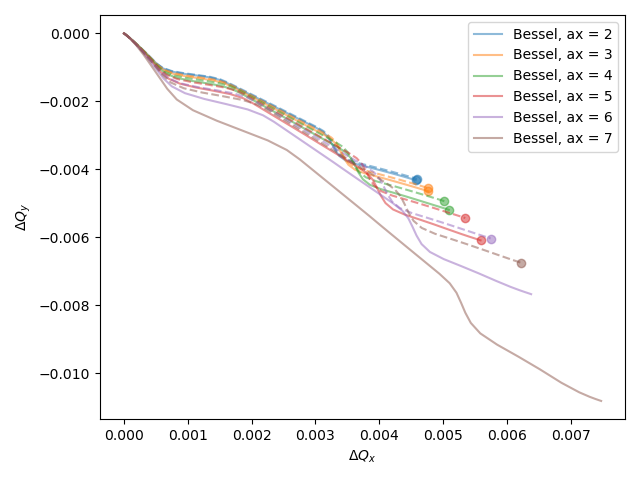

In [38]:
Qx_0,Qy_0 = 0.31,0.32
AX_vec = [2,3,4,5,6,7]

plt.close('all')
plt.figure()
color = 0
for AX,migr_Bess_X,migr_Bess_Y,migr_oct_X,migr_oct_Y in zip(AX_vec, Bess_migration_X, Bess_migration_Y,oct_migration_X, oct_migration_Y):
    
    plt.plot(migr_Bess_X,migr_Bess_Y,'-',alpha=0.5,color=f'C{color}',label=f'Bessel, ax = {AX}')
    
    plt.plot(migr_Bess_X[-1:],migr_Bess_Y[-1:],'o',alpha=0.5,color=f'C{color}')
    
    plt.plot(migr_oct_X,migr_oct_Y,'--',alpha=0.5,color=f'C{color}')
    
    plt.plot(migr_oct_X[-1:],migr_oct_Y[-1:],'o',alpha=0.5,color=f'C{color}')
    
    color += 1
    
plt.legend()
plt.xlabel(r'$\Delta Q_x$')
plt.ylabel(r'$\Delta Q_y$')
plt.tight_layout()

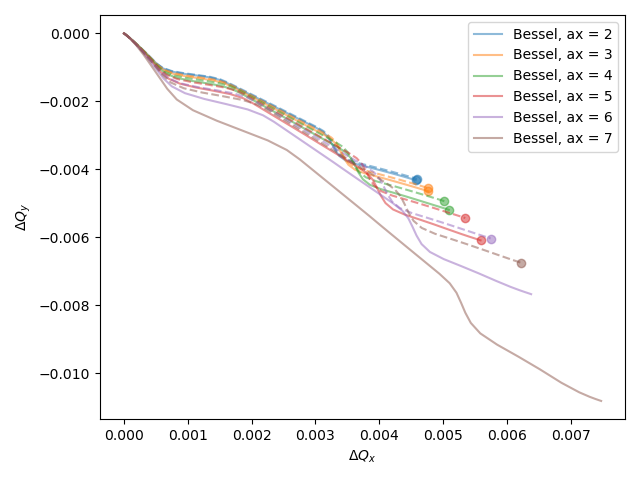

In [39]:
Qx_0,Qy_0 = 0.31,0.32
AX_vec = [2,3,4,5,6,7]

plt.close('all')
plt.figure()
color = 0
for AX,migr_Bess_X,migr_Bess_Y,migr_oct_X,migr_oct_Y in zip(AX_vec, Bess_migration_X, Bess_migration_Y,oct_migration_X, oct_migration_Y):
    
    plt.plot(migr_Bess_X,migr_Bess_Y,'-',alpha=0.5,color=f'C{color}',label=f'Bessel, ax = {AX}')
    
    plt.plot(migr_Bess_X[-1:],migr_Bess_Y[-1:],'o',alpha=0.5,color=f'C{color}')
    
    plt.plot(migr_oct_X,migr_oct_Y,'--',alpha=0.5,color=f'C{color}')
    
    plt.plot(migr_oct_X[-1:],migr_oct_Y[-1:],'o',alpha=0.5,color=f'C{color}')
    
    color += 1
    
plt.legend()
plt.xlabel(r'$\Delta Q_x$')
plt.ylabel(r'$\Delta Q_y$')
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


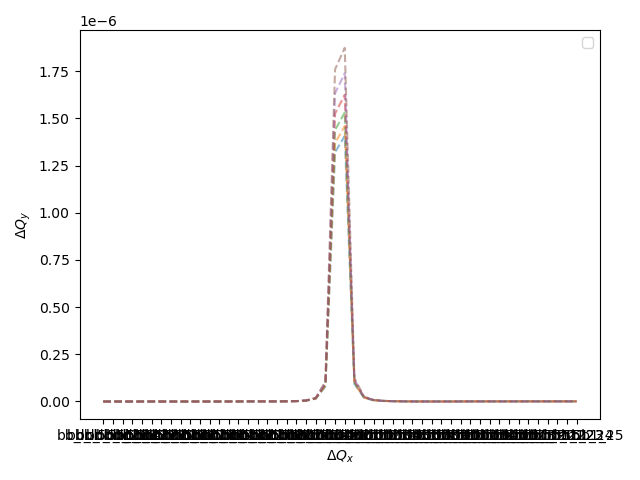

In [14]:
Qx_0,Qy_0 = 0.31,0.32
AX_vec = [2,3,4,5,6,7]

plt.close('all')
plt.figure()
color = 0
for AX,migr_Bess_X,migr_Bess_Y,migr_oct_X,migr_oct_Y in zip(AX_vec, Bess_migration_X, Bess_migration_Y,oct_migration_X, oct_migration_Y):
    
    plt.plot(migr_oct_X/study['betx']**2,'--',alpha=0.5,color=f'C{color}')
    
    #plt.plot(migr_oct_X[-1:],migr_oct_Y[-1:],'o',alpha=0.5,color=f'C{color}')
    
    color += 1
    
plt.legend()
plt.xlabel(r'$\Delta Q_x$')
plt.ylabel(r'$\Delta Q_y$')
plt.tight_layout()

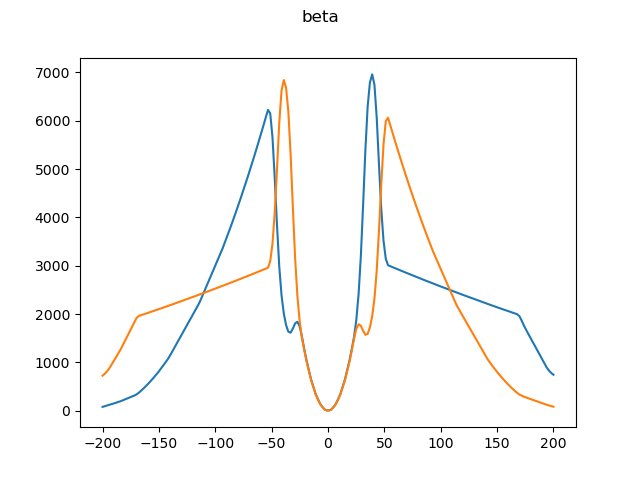

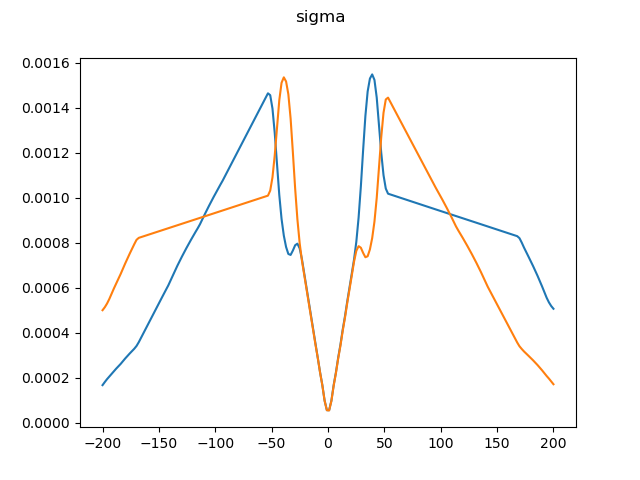

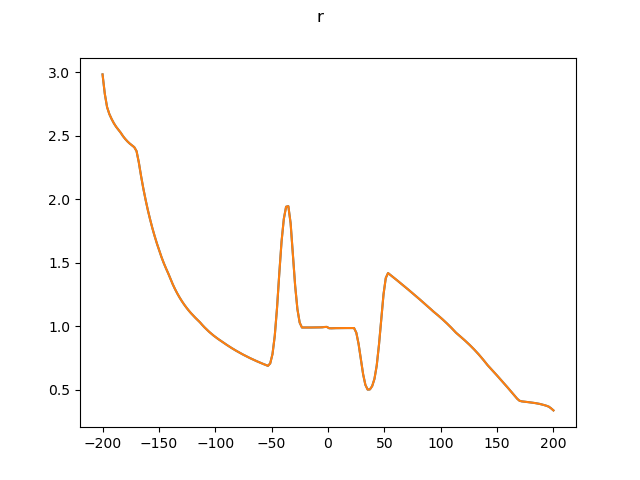

In [36]:
plt.close('all')

_IP = IP5

s_vec  = np.linspace(-200,200,200)
r_vec  = _IP.b2.get_sigy(s_vec)/_IP.b2.get_sigx(s_vec)
betx   = _IP.b2.get_betx(s_vec)
bety   = _IP.b2.get_bety(s_vec)
sigx   = _IP.b2.get_sigx(s_vec)
sigy   = _IP.b2.get_sigy(s_vec)


xi_x_s = _IP.b2.Nb*cst.r_p*_IP.b2.get_betx(s_vec)/(2*np.pi*_IP.b1.gamma_r*_IP.b2.get_sigx(s_vec)**2*(1+r_vec))
xi_y_s = _IP.b2.Nb*cst.r_p*_IP.b2.get_bety(s_vec)/(2*np.pi*_IP.b1.gamma_r*_IP.b2.get_sigy(s_vec)**2*(1+1/r_vec))


#study.insert(0,'xi_x',xi_x_s)
#study.insert(1,'xi_y',xi_y_s)

plt.figure()
plt.suptitle('beta')
plt.plot(s_vec,betx)
plt.plot(s_vec,bety)



plt.figure()
plt.suptitle('sigma')
plt.plot(s_vec,sigx)
plt.plot(s_vec,sigy)


plt.figure()
plt.suptitle('r')
plt.plot(s_vec,r_vec)
plt.plot(s_vec,r_vec)





In [12]:
for index, _lr in study.iterrows():
    print(_lr['xi_x']*(1+_lr['r'])/_lr['dx_n']**2,_lr['xi_x'],(1+_lr['r']),1/_lr['dx_n']**2)

7134.21568096663 0.006192402460890325 2.031266302089362 567179.0702927976
10357.57495284708 0.006184915002722838 2.0284103521071946 825597.8072117112
11950.234458043366 0.0061814257206010805 2.027343438973794 953587.2709709225
12891.296334752944 0.006179547467638082 2.0267727646923275 1029283.1411759111
13511.410939605037 0.00617840079107888 2.026411175478474 1079187.8659183353
13950.52716475122 0.006177640339236525 2.026158189892289 1114537.4079116946
12772.373095683042 0.005454300293894293 1.9444884784174945 1204279.1771931862
8808.336135030087 0.003577429477022556 1.7191646245864667 1432205.483582611
5869.405622476986 0.002302549143631437 1.5473066116407983 1647437.0707576473
5582.4289707967 0.0021563051609161444 1.5259080324725645 1696620.1648516755
7107.126292464913 0.0027277065955460256 1.606945743275932 1621418.655250117
12131.55245794899 0.00469833385115634 1.856021895153801 1391199.496852956
20553.41976771295 0.00819569804424067 2.242755270497833 1118191.6808661995
25635.72879

In [6]:
_lr['xi_x']*(1+_lr['r'])/_lr['dx_n']**2

5.802846653563836e-06

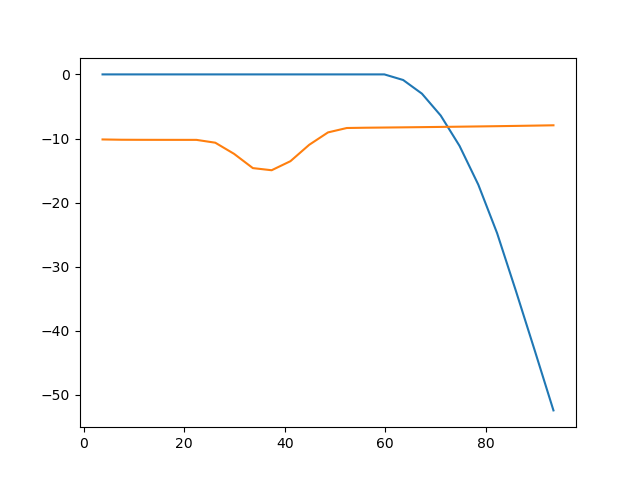

In [152]:
plt.figure()
plt.plot(study['s'],study['dx_n'])
plt.plot(study['s'],study['dy_n'])

/tmp/ipykernel_1479624/2623392542.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


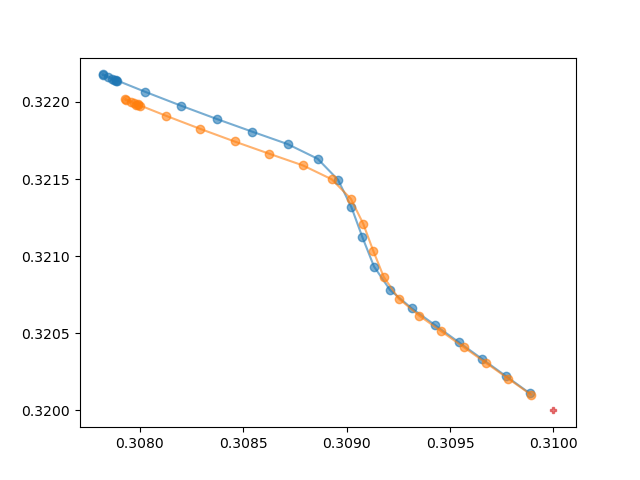

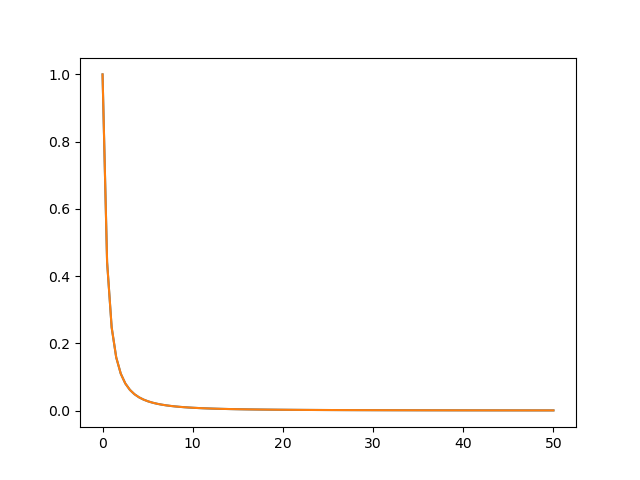

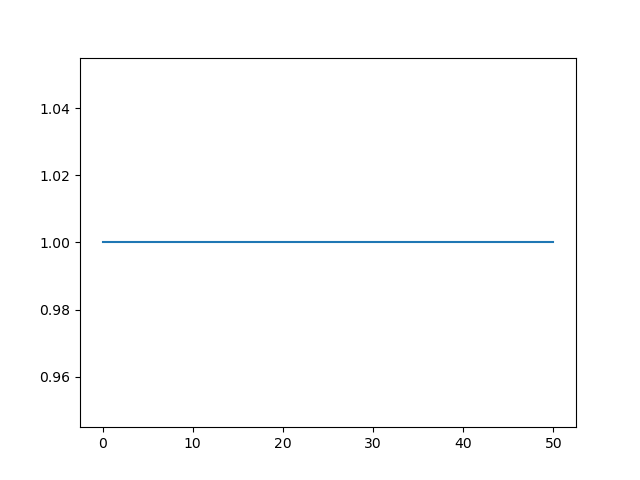

In [76]:


def dtuneHeadOn_round_generating(t,Jx,Jy,emitt):
    term1 = 1/(1+t)**2*np.exp(-(Jx+Jy)/(2*emitt*(1+t)))
    term2 = sciSpec.iv(0,Jy/(2*emitt*(1+t)))
    term3 = sciSpec.iv(0,Jx/(2*emitt*(1+t)))-sciSpec.iv(1,Jx/(2*emitt*(1+t)))
    return term1*term2*term3



t_vec = np.linspace(0,50,100)
plt.figure()
plt.plot(t_vec,HeadOn_round_generating(t_vec,0,0,1))
plt.plot(t_vec,dtuneHeadOn_round_generating(t_vec,0,0,IP1.b1.emittx))


plt.figure()
plt.plot(t_vec,dtuneHeadOn_round_generating(t_vec,0,0,IP1.b1.emittx)/HeadOn_round_generating(t_vec,0,0,1))